In [1]:
import h3
import pandas as pd
from glob import glob
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os
import seaborn as sns

p = os.path.join

sns.set()
sns.set_context('poster')

In [2]:
def loadDataFrame(city):
    no_spaces = city.replace(' ', '').lower()
    return pd.read_csv(p('..', 'data', city, f'{no_spaces}2019.csv'), index_col=0)

In [3]:
neighbors = pd.concat([pd.read_csv(f, index_col=0) for f in glob('../data/Waze Data/neighbors/*.csv')])
stations = pd.read_csv('../data/Waze Data/X_stations.csv', index_col=0)

In [4]:
def using_mean(h3id):
    ns = neighbors.reindex(h3.k_ring(h3id, 1)).dropna()
    complete = pd.concat([ns, stations.reindex([h3id])])
    final = complete.mean()
    final['bool_highway'] = complete.bool_highway.max()
    final['bool_ramps'] = complete.bool_ramps.max()
    #final['max_length'] = complete.max_length.max()
    return final

In [5]:
with_mean = pd.DataFrame([using_mean(h3id) for h3id in stations.index])
with_mean.index = stations.index

## Test

In [6]:
models ='../models/models.p'

updated_models = pickle.load(open(models, "rb"))

param_norm ='../models/data.p'

norm = pickle.load(open(param_norm, "rb"))

In [7]:
cities = ['Lima', 'Montevideo', 'Quito','Sao Paulo']
ys = {c:loadDataFrame(c) for c in cities}

In [8]:
dfTemp = pd.DataFrame(columns=with_mean.columns)
dfTemp.loc[0] = norm[1][1]['model_data']['scaler-data_min_']
dfTemp.loc[1] =norm[1][1]['model_data']['scaler-data_max_']

# Create MaxMin scaler
scaler = MinMaxScaler()
scaler.fit(dfTemp)
x_scaled = scaler.transform(with_mean)
df_X = pd.DataFrame(x_scaled)
df_X.columns=with_mean.columns
df_X.index = with_mean.index

In [9]:
y_hat = pd.DataFrame(updated_models['NO2'].predict(df_X))
y_hat.index = df_X.index

C:\Users\USER\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [10]:
def adapt_linear(y_original, y_pred):
    linear = LinearRegression()
    plt.figure(figsize=(15, 6))
    y_shaped = y_pred.values.reshape(-1, 1)
    fitted = linear.fit(y_shaped, y_original)
    y_fitted = fitted.predict(y_shaped)
    diag = [y_original.min(), y_original.max()]
    
    sns.scatterplot(x=y_original, y=y_fitted, label="Adapted")
    sns.scatterplot(x=y_original, y=y_pred.values, label="Without adapting")
    plt.plot(diag, diag,'--', c='black', alpha=0.25, label="Main Diagonal")
    plt.xlabel("Original")
    plt.ylabel("Predicted")
    plt.axis('equal')
    
    plt.legend()
    return fitted

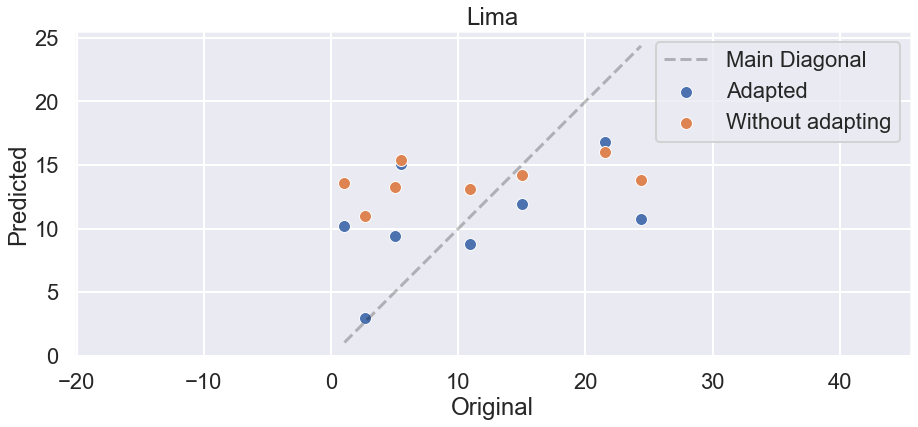

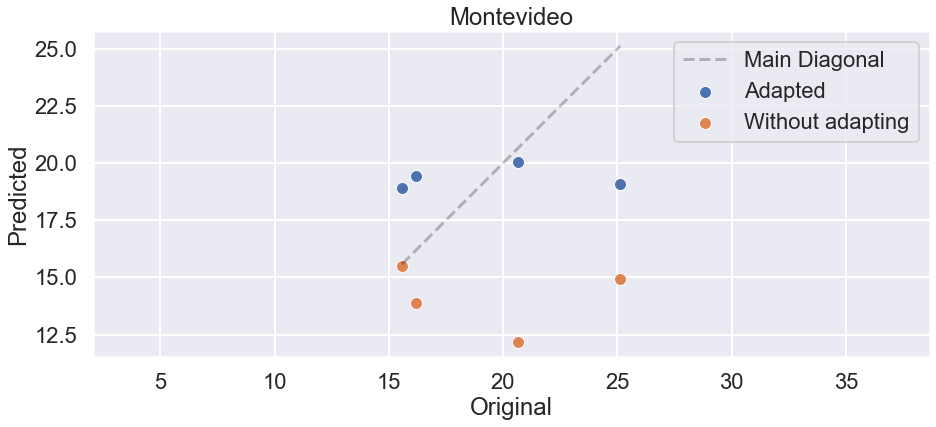

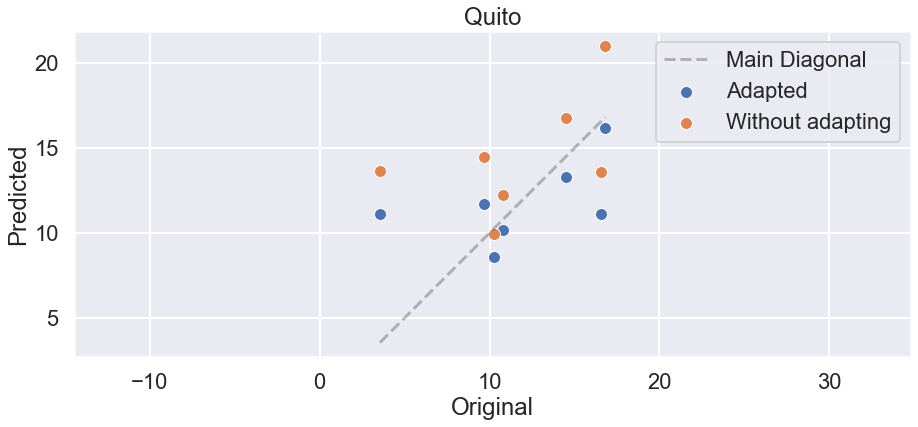

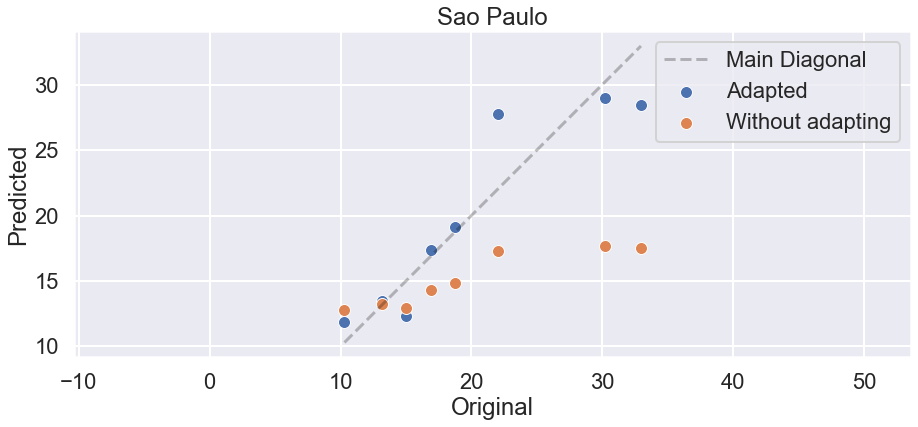

In [11]:
linear_regs = {}
for c in cities:
    y_pred = y_hat.reindex(ys[c].index)[0].reindex(with_mean.index).dropna()
    y_correct = ys[c].NO2.reindex(with_mean.index).dropna()
    lin = adapt_linear(y_correct, y_pred)
    linear_regs[c] = lin
    plt.title(c)

# Generating final csv with predictions

This is the step where we take all of the data from Waze and predict the NO2 values

In [12]:
def generateFor(c):
    # Gets the original actual recorded value
    y_original = loadDataFrame(c)['NO2']
    # Gets the h3id all neighbors in a 3 hexa distance
    ns = {r for h in y_original.index for r in h3.k_ring(h, 3)}
    # For each h3id, gets the mean of its direct neighbors. This will be our X
    with_mean = pd.DataFrame([using_mean(h3id) for h3id in ns], index=ns).dropna()
    city_df = pd.DataFrame(scaler.transform(with_mean))
    city_df.columns=with_mean.columns
    city_df.index = with_mean.index
    
    # Runs the raw prediction
    y_pred = updated_models['NO2'].predict(city_df)
    city_df['city'] = c
    city_df['NO2'] = y_original
    city_df['NO2_pred'] = y_pred
    # Adjusts it linearly with the fitted coefficients for the given city
    city_df['NO2_adjusted'] = linear_regs[c].predict(y_pred.reshape(-1, 1))
    return city_df

In [13]:
pd.concat([generateFor(c) for c in cities]).to_csv('final_prediction.csv')

C:\Users\USER\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
